# Generating Pixel Maps from .edf data

In [190]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf

import dhedfreader
from PIL import Image

## Loading the data

In [222]:
first = pd.DataFrame()
raw = read_raw_edf('data/SC4001E0-PSG.edf')
sampling_rate = raw.info['sfreq']

raw_eeg_fpz = raw.to_data_frame(scaling_time=100.0)['EEG Fpz-Cz']
raw_eeg_fpz = raw_eeg_fpz.to_frame()
raw_eeg_fpz.set_index(np.arange(len(raw_eeg_fpz)))
raw_eeg_fpz = raw_eeg_fpz.values.tolist()

raw_eeg_pz = raw.to_data_frame(scaling_time=100.0)['EEG Pz-Oz']
raw_eeg_pz = raw_eeg_pz.to_frame()
raw_eeg_pz.set_index(np.arange(len(raw_eeg_pz)))
raw_eeg_pz = raw_eeg_pz.values.tolist()

raw_eog = raw.to_data_frame(scaling_time=100.0)['EOG horizontal']
raw_eog = raw_eog.to_frame()
raw_eog.set_index(np.arange(len(raw_eog)))
raw_eog = raw_eog.values.tolist()

raw_emg = raw.to_data_frame(scaling_time=100.0)['EMG submental']
raw_emg = raw_emg.to_frame()
raw_emg.set_index(np.arange(len(raw_emg)))
raw_emg = raw_emg.values.tolist()

first['EEG Fpz-Cz'] = raw_eeg_fpz
first['EEG Pz-Oz'] = raw_eeg_pz
first['EOG horizontal'] = raw_eog
first['EMG submental'] = raw_emg

Extracting EDF parameters from data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-222-915717e81f69>:2: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw = read_raw_edf('data/SC4001E0-PSG.edf')
<ipython-input-222-915717e81f69>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw = read_raw_edf('data/SC4001E0-PSG.edf')


Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...


In [192]:
def epoch_gen(data, epoch_length, fs):
    print("Generating Epochs")
    eeg_data = data
    L = epoch_length * fs # signal length
    epochs = np.reshape(eeg_data, (-1, L))
    return epochs

In [193]:
def extract_features_from_epochs(epochs, fs, epoch_length):
    print("Extracting Features")
    N = epochs.shape[0]
    L = epoch_length * fs # signal length
    f = np.linspace(0, L-1, L) * fs/L
    delta1, delta2, theta1, theta2, alpha1, alpha2, beta1, beta2 = 0, 4, 4, 8, 8, 13, 13, 30
    all_indices = np.where((f <= beta2))    
    delta_indices = np.where((f >= delta1) & (f <= delta2))
    theta_indices = np.where((f >= theta1) & (f <= theta2))
    alpha_indices = np.where((f >= alpha1) & (f <= alpha2))
    beta_indices = np.where((f >= beta1) & (f <= beta2))
    nr_features = 6 # number of features to be calculated
    features = np.zeros((N, nr_features))
    # calculation of delta, theta, alpha and beta band power ratios
    for index in range(N):    
        epoch = epochs[index, :]
        Y = abs(np.fft.fft(epoch))
        mean_total_power = np.mean(Y[all_indices])
        features[index,:] = (mean_total_power, np.mean(f[all_indices] * Y[all_indices]) / mean_total_power, 
        np.mean(Y[delta_indices]) / mean_total_power, np.mean(Y[theta_indices]) / mean_total_power, 
        np.mean(Y[alpha_indices]) / mean_total_power, np.mean(Y[beta_indices]) / mean_total_power)
    return preprocessing.scale(features)

In [194]:
def rescale_linear(array, new_min=0, new_max=255):
    """Rescale an arrary linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [195]:
eeg_data_1 = epoch_gen(raw_eeg_fpz, 30, 100)
eeg_features_1 = extract_features_from_epochs(eeg_data_1, 30, 100)
eeg_features_1 = rescale_linear(eeg_features_1)

Generating Epochs
Extracting Features


In [196]:
eeg_data_2 = epoch_gen(raw_eeg_pz, 30, 100)
eeg_features_2 = extract_features_from_epochs(eeg_data_2, 30, 100)
eeg_features_2 = rescale_linear(eeg_features_2)

Generating Epochs
Extracting Features


In [207]:
eog_data = epoch_gen(raw_eog, 30, 100)
eog_features = extract_features_from_epochs(eog_data, 30, 100)
eog_features = rescale_linear(eog_features)

Generating Epochs
Extracting Features


In [208]:
emg_data = epoch_gen(raw_emg, 30, 100)
emg_features = extract_features_from_epochs(emg_data, 30, 100)
emg_features = rescale_linear(emg_features)

Generating Epochs
Extracting Features


In [210]:
img = Image.new('RGB', (6,4), "white") # create a new black image
pixelMap = img.load() # create the pixel map

for j in range(img.size[0]):
    pixelMap[j, 0] = (int(eeg_features_1[0][j]), 0, 0)

for j in range(img.size[0]):
    pixelMap[j, 1] = (int(eeg_features_2[0][j]), 0, 0)

for j in range(img.size[0]):
    pixelMap[j, 2] = (0, int(eog_features[0][j]), 0)

for j in range(img.size[0]):
    pixelMap[j, 3] = (0, 0, int(emg_features[0][j]))
    

img.show()

# EMG Power Spectrum Analysis

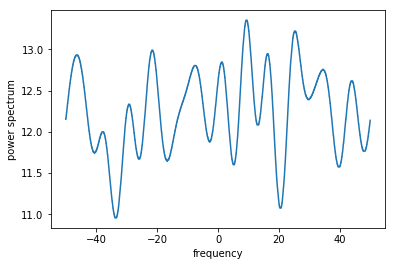

In [244]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

data = np.array(raw_emg[:3000])

ps = np.abs(np.fft.fft(data))**2

time_step = 1 / 100
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)


plt.xlabel("frequency")
plt.ylabel("power spectrum")
plt.plot(freqs[idx], ps[idx])